In [1]:
!pip install -q transformers opendatasets emoji scikit-learn optuna

import os, re, time, random, json
import emoji
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 37.1 MB/s eta 0:00:00


In [2]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/sandhyapeesara/cyberbullying-detection-dataset",
    data_dir=".",
    force=True
)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: spacekeggle
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sandhyapeesara/cyberbullying-detection-dataset


100%|██████████| 6.51M/6.51M [00:00<00:00, 1.45GB/s]

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Available Device:", device)


Available Device: cuda


In [4]:
def textFixNormlize(text):
    text = str(text).lower()
    text = re.sub(r"\S+@\S+\.\S+", "", text)     # remove emails
    text = re.sub(r'@\w+', '', text)            # remove mentions
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'#(\w+)', r'\1', text)       # remove hashtag symbol only
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data_df = pd.read_json(
    "/content/cyberbullying-detection-dataset/Cyber_Bully_Data.json",
    lines=True
)

data_df["clean_text"] = data_df["text"].astype(str).apply(textFixNormlize)

le = LabelEncoder()
data_df["label_id"] = le.fit_transform(data_df["label"])

data_df.dropna(subset=["clean_text", "label_id"], inplace=True)
data_df.drop_duplicates(subset=["clean_text", "label_id"], inplace=True)

print("Shape after cleaning:", data_df.shape)
print("Labels:", list(le.classes_))
print("\nClass distribution:")
print(data_df["label"].value_counts())

Shape after cleaning: (99967, 4)
Labels: ['ethnicity/race', 'gender/sexual', 'not_cyberbullying', 'religion']

Class distribution:
label
not_cyberbullying    49983
ethnicity/race       17000
gender/sexual        17000
religion             15984
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Character length stats:
count    99967.000000
mean       124.464573
std         82.829636
min          4.000000
25%         60.000000
50%        101.000000
75%        174.000000
max       2541.000000
Name: char_len, dtype: float64


Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors



Token length stats:
count    99967.000000
mean        33.858203
std         22.692880
min          1.000000
25%         17.000000
50%         28.000000
75%         47.000000
max        773.000000
Name: tok_len, dtype: float64


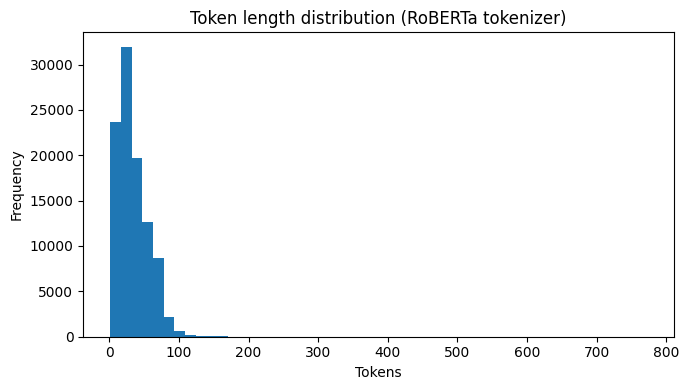

In [5]:
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

data_df["char_len"] = data_df["clean_text"].str.len()
print("\nCharacter length stats:")
print(data_df["char_len"].describe())

data_df["tok_len"] = data_df["clean_text"].apply(lambda x: len(tokenizer.tokenize(str(x))))
print("\nToken length stats:")
print(data_df["tok_len"].describe())

plt.figure(figsize=(7,4))
plt.hist(data_df["tok_len"], bins=50)
plt.title("Token length distribution (RoBERTa tokenizer)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [6]:
X = np.array(data_df["clean_text"])
y = np.array(data_df["label_id"])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.50, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)/len(X)*100:.2f}%")
print(f"Val:   {len(X_val)/len(X)*100:.2f}%")
print(f"Test:  {len(X_test)/len(X)*100:.2f}%")

Train: 50.00%
Val:   25.00%
Test:  25.00%


In [7]:
class MyDataset(Dataset):
    def __init__(self, X, Y, tokenizer, max_len):
        self.X = X
        self.Y = Y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = str(self.X[idx])
        label = int(self.Y[idx])

        enc = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [8]:
class MyModel(nn.Module):
    def __init__(self, base_model, num_classes, dropout=0.30):
        super().__init__()
        self.base = base_model
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 256)   # roberta-base hidden size = 768
        self.act = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.base(input_ids=input_ids, attention_mask=attention_mask)
        pooled = out.last_hidden_state[:, 0]  # <s> token embedding (RoBERTa)
        x = self.dropout1(pooled)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout2(x)
        return self.fc2(x)


In [19]:
def run_roberta_experiment(
    run_name="roberta_run",
    max_len=100,
    batch_size=32,
    epochs=3,
    lr=2e-5,
    dropout=0.30,
    unfreeze_last_n=2
):
    # Fresh tokenizer/model for fair runs
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    base_model = AutoModel.from_pretrained(MODEL_NAME)

    num_classes = len(le.classes_)

    # DataLoaders
    train_loader = DataLoader(
        MyDataset(X_train, y_train, tokenizer, max_len),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        MyDataset(X_val, y_val, tokenizer, max_len),
        batch_size=batch_size,
        shuffle=False
    )
    test_loader = DataLoader(
        MyDataset(X_test, y_test, tokenizer, max_len),
        batch_size=batch_size,
        shuffle=False
    )

    # Class weights (helps imbalance)
    classes = np.unique(y_train)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    cw = torch.tensor(cw, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=cw)

    # Build model
    model = MyModel(base_model, num_classes, dropout=dropout).to(device)

    # Freeze all then unfreeze last N transformer layers
    for p in model.base.parameters():
        p.requires_grad = False
    for p in model.base.encoder.layer[-unfreeze_last_n:].parameters():
        p.requires_grad = True

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_acc = -1.0
    best_state_dict = None

    start_time = time.time()

    for epoch in range(epochs):
        # ---- TRAIN
        model.train()
        train_loss_sum, train_correct, train_total = 0.0, 0, 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss_sum / train_total
        avg_train_acc = train_correct / train_total

        # ---- VAL
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

                val_loss_sum += loss.item() * labels.size(0)
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss_sum / val_total
        avg_val_acc = val_correct / val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(avg_train_acc)
        history["val_acc"].append(avg_val_acc)

        print(
            f"[{run_name}] Epoch {epoch+1}/{epochs} | "
            f"Train Loss {avg_train_loss:.4f} Acc {avg_train_acc*100:.2f}% | "
            f"Val Loss {avg_val_loss:.4f} Acc {avg_val_acc*100:.2f}%"
        )

        # Keep best model in memory (no saving)
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            print(f"✅ Best model updated in memory (Val Acc {best_val_acc*100:.2f}%)")

    train_time_sec = time.time() - start_time
    print(f"[{run_name}] Training time: {train_time_sec:.2f} seconds")

    # ---- Load best weights from memory
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    model = model.to(device)
    model.eval()

    # ---- TEST
    all_preds, all_labels = [], []
    test_loss_sum, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            test_loss_sum += loss.item() * labels.size(0)

            preds = torch.argmax(logits, dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    avg_test_loss = test_loss_sum / test_total
    avg_test_acc = test_correct / test_total

    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")
    macro_prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    macro_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    metrics = {
        "run_name": run_name,
        "best_val_acc": float(best_val_acc),
        "test_loss": float(avg_test_loss),
        "test_acc": float(avg_test_acc),
        "macro_f1": float(macro_f1),
        "weighted_f1": float(weighted_f1),
        "macro_precision": float(macro_prec),
        "macro_recall": float(macro_rec),
        "training_time_sec": float(train_time_sec),
        "config": {
            "model_name": MODEL_NAME,
            "max_len": max_len,
            "batch_size": batch_size,
            "epochs": epochs,
            "lr": lr,
            "dropout": dropout,
            "unfreeze_last_n": unfreeze_last_n
        }
    }

    print(f"\n✅ TEST RESULTS | Loss: {avg_test_loss:.4f} | Accuracy: {avg_test_acc*100:.2f}%\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(values_format="d", cmap="Blues")
    plt.title(f"Confusion Matrix (Counts) — {run_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return metrics, history


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_baseline] Epoch 1/3 | Train Loss 0.1914 Acc 93.05% | Val Loss 0.0541 Acc 98.66%
✅ Best model updated in memory (Val Acc 98.66%)
[roberta_baseline] Epoch 2/3 | Train Loss 0.0482 Acc 98.76% | Val Loss 0.0421 Acc 99.04%
✅ Best model updated in memory (Val Acc 99.04%)
[roberta_baseline] Epoch 3/3 | Train Loss 0.0362 Acc 99.08% | Val Loss 0.0422 Acc 98.70%
[roberta_baseline] Training time: 691.78 seconds

✅ TEST RESULTS | Loss: 0.0390 | Accuracy: 98.98%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.98      0.99      0.98      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

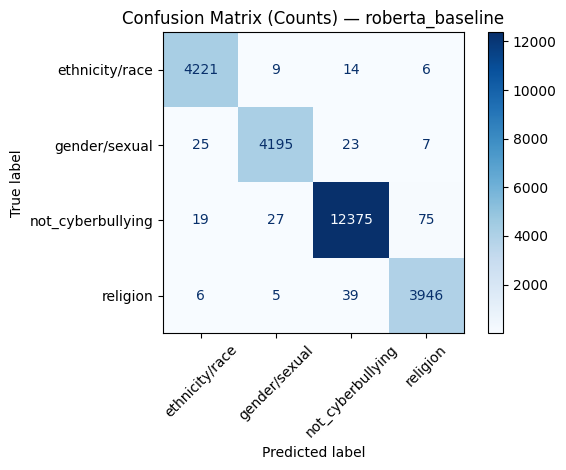

In [21]:
baseline_metrics, baseline_history = run_roberta_experiment(
    run_name="roberta_baseline",
    max_len=100,
    batch_size=32,
    epochs=3,
    lr=2e-5,
    dropout=0.30,
    unfreeze_last_n=2,

)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_manual_1_lr2e-05_len100_do0.3] Epoch 1/2 | Train Loss 0.1914 Acc 93.05% | Val Loss 0.0541 Acc 98.66%
✅ Best model updated in memory (Val Acc 98.66%)
[roberta_manual_1_lr2e-05_len100_do0.3] Epoch 2/2 | Train Loss 0.0482 Acc 98.76% | Val Loss 0.0421 Acc 99.04%
✅ Best model updated in memory (Val Acc 99.04%)
[roberta_manual_1_lr2e-05_len100_do0.3] Training time: 457.39 seconds

✅ TEST RESULTS | Loss: 0.0390 | Accuracy: 98.98%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.98      0.99      0.98      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

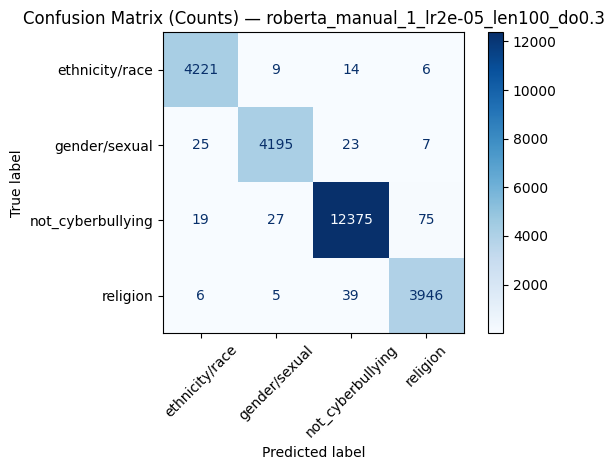

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_manual_2_lr3e-05_len100_do0.3] Epoch 1/2 | Train Loss 0.1551 Acc 94.50% | Val Loss 0.0551 Acc 98.64%
✅ Best model updated in memory (Val Acc 98.64%)
[roberta_manual_2_lr3e-05_len100_do0.3] Epoch 2/2 | Train Loss 0.0441 Acc 98.79% | Val Loss 0.0403 Acc 99.07%
✅ Best model updated in memory (Val Acc 99.07%)
[roberta_manual_2_lr3e-05_len100_do0.3] Training time: 457.30 seconds

✅ TEST RESULTS | Loss: 0.0378 | Accuracy: 99.04%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.98      0.99      0.98      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

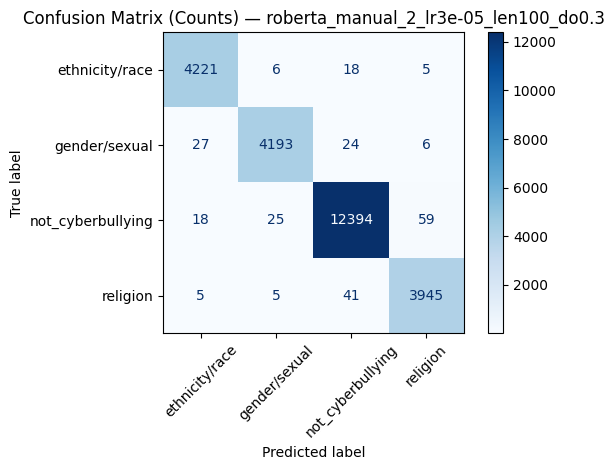

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_manual_3_lr2e-05_len128_do0.3] Epoch 1/2 | Train Loss 0.1898 Acc 93.30% | Val Loss 0.0519 Acc 98.74%
✅ Best model updated in memory (Val Acc 98.74%)
[roberta_manual_3_lr2e-05_len128_do0.3] Epoch 2/2 | Train Loss 0.0505 Acc 98.71% | Val Loss 0.0409 Acc 99.10%
✅ Best model updated in memory (Val Acc 99.10%)
[roberta_manual_3_lr2e-05_len128_do0.3] Training time: 581.59 seconds

✅ TEST RESULTS | Loss: 0.0387 | Accuracy: 99.13%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.99      0.99      0.99      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

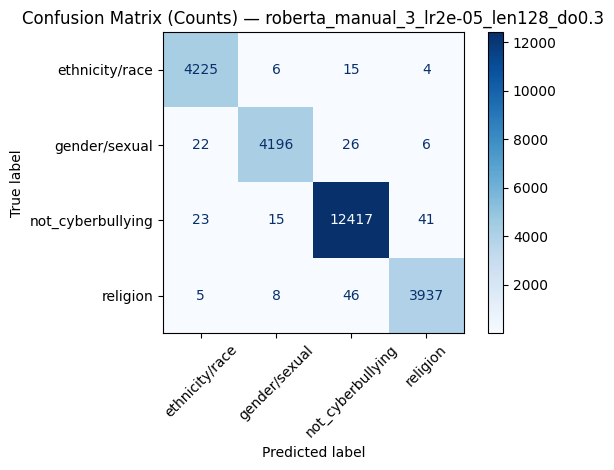

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_manual_4_lr2e-05_len100_do0.4] Epoch 1/2 | Train Loss 0.2052 Acc 92.37% | Val Loss 0.0549 Acc 98.61%
✅ Best model updated in memory (Val Acc 98.61%)
[roberta_manual_4_lr2e-05_len100_do0.4] Epoch 2/2 | Train Loss 0.0502 Acc 98.71% | Val Loss 0.0437 Acc 99.09%
✅ Best model updated in memory (Val Acc 99.09%)
[roberta_manual_4_lr2e-05_len100_do0.4] Training time: 457.61 seconds

✅ TEST RESULTS | Loss: 0.0414 | Accuracy: 99.06%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.98      0.99      0.99      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

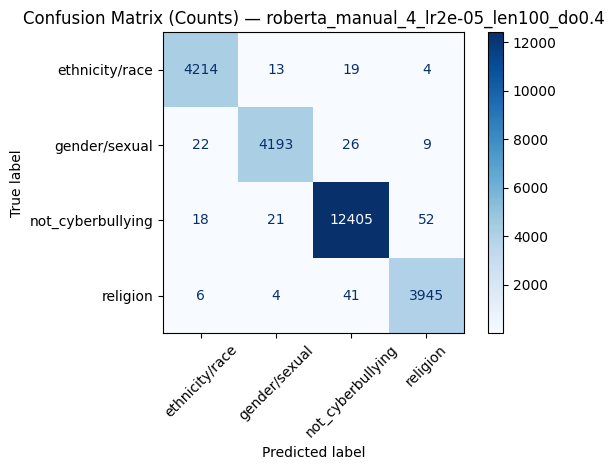

,run_name,best_val_acc,test_acc,macro_f1,training_time_sec
2,roberta_manual_3_lr2e-05_len128_do0.3,0.990957,0.991317,0.990248,581.585775
3,roberta_manual_4_lr2e-05_len100_do0.4,0.990877,0.990597,0.989397,457.613834
1,roberta_manual_2_lr3e-05_len100_do0.3,0.990717,0.990437,0.989312,457.303420
0,roberta_manual_1_lr2e-05_len100_do0.3,0.990357,0.989797,0.988583,457.394164


In [22]:
manual_space = [
    {"lr": 2e-5, "max_len": 100, "dropout": 0.30},
    {"lr": 3e-5, "max_len": 100, "dropout": 0.30},
    {"lr": 2e-5, "max_len": 128, "dropout": 0.30},
    {"lr": 2e-5, "max_len": 100, "dropout": 0.40},
]

manual_results = []
for i, cfg in enumerate(manual_space, start=1):
    set_seed(42)
    run_name = f"roberta_manual_{i}_lr{cfg['lr']}_len{cfg['max_len']}_do{cfg['dropout']}"
    metrics, _ = run_roberta_experiment(
        run_name=run_name,
        max_len=cfg["max_len"],
        batch_size=32,
        epochs=2,
        lr=cfg["lr"],
        dropout=cfg["dropout"],
        unfreeze_last_n=2,

    )
    manual_results.append(metrics)

manual_df = pd.DataFrame(manual_results).sort_values("best_val_acc", ascending=False)
manual_df[["run_name","best_val_acc","test_acc","macro_f1","training_time_sec"]]


[I 2025-12-18 20:17:06,585] A new study created in memory with name: no-name-4073fd1a-872c-4f58-b306-bdc70a3f3c66
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_optuna_lr2.34e-05_len128_do0.23] Epoch 1/2 | Train Loss 0.1676 Acc 94.27% | Val Loss 0.0522 Acc 98.78%
✅ Best model updated in memory (Val Acc 98.78%)
[roberta_optuna_lr2.34e-05_len128_do0.23] Epoch 2/2 | Train Loss 0.0476 Acc 98.75% | Val Loss 0.0400 Acc 99.17%
✅ Best model updated in memory (Val Acc 99.17%)
[roberta_optuna_lr2.34e-05_len128_do0.23] Training time: 580.89 seconds

✅ TEST RESULTS | Loss: 0.0373 | Accuracy: 99.18%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.99      0.99      0.99      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

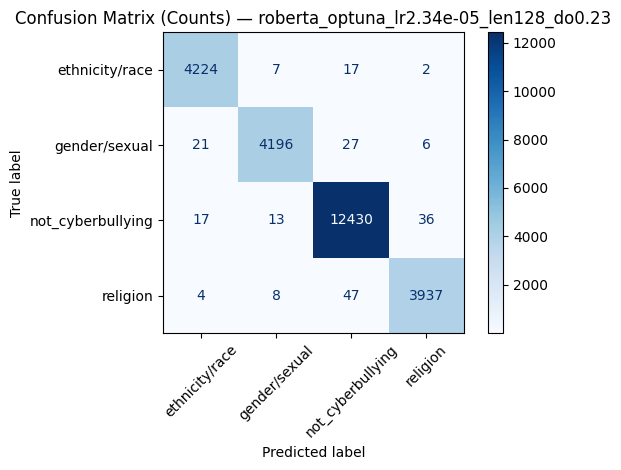

[I 2025-12-18 20:28:05,533] Trial 0 finished with value: 0.9917173495518566 and parameters: {'lr': 2.342457631106799e-05, 'max_len': 128, 'dropout': 0.23060674293378702}. Best is trial 0 with value: 0.9917173495518566.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_optuna_lr1.52e-05_len100_do0.50] Epoch 1/2 | Train Loss 0.2702 Acc 89.57% | Val Loss 0.0594 Acc 98.46%
✅ Best model updated in memory (Val Acc 98.46%)
[roberta_optuna_lr1.52e-05_len100_do0.50] Epoch 2/2 | Train Loss 0.0587 Acc 98.52% | Val Loss 0.0460 Acc 98.98%
✅ Best model updated in memory (Val Acc 98.98%)
[roberta_optuna_lr1.52e-05_len100_do0.50] Training time: 458.90 seconds

✅ TEST RESULTS | Loss: 0.0439 | Accuracy: 98.96%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.98      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.98      0.99      0.98      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

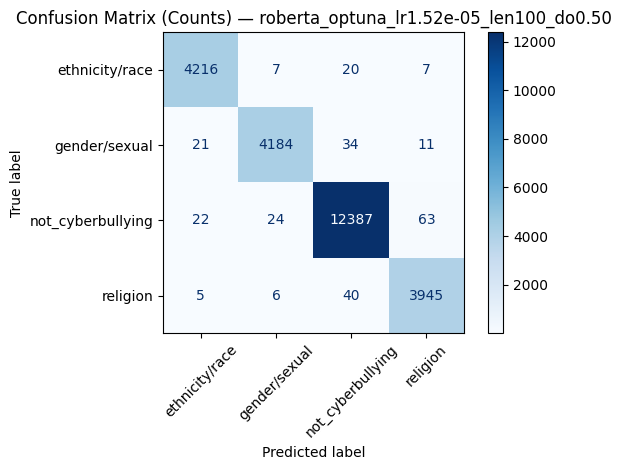

[I 2025-12-18 20:36:48,253] Trial 1 finished with value: 0.989836747759283 and parameters: {'lr': 1.5214636726809551e-05, 'max_len': 100, 'dropout': 0.49683143990509077}. Best is trial 0 with value: 0.9917173495518566.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_optuna_lr2.75e-05_len128_do0.46] Epoch 1/2 | Train Loss 0.1836 Acc 93.53% | Val Loss 0.0544 Acc 98.69%
✅ Best model updated in memory (Val Acc 98.69%)
[roberta_optuna_lr2.75e-05_len128_do0.46] Epoch 2/2 | Train Loss 0.0505 Acc 98.76% | Val Loss 0.0400 Acc 99.16%
✅ Best model updated in memory (Val Acc 99.16%)
[roberta_optuna_lr2.75e-05_len128_do0.46] Training time: 580.94 seconds

✅ TEST RESULTS | Loss: 0.0365 | Accuracy: 99.18%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      0.99      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.99      0.99      0.99      3996

         accuracy                           0.99     24992
        macro avg       0.99      0.99      0.99     24992
     weighted avg       0.99      0.99      0.99     24992



<Figure size 700x600 with 0 Axes>

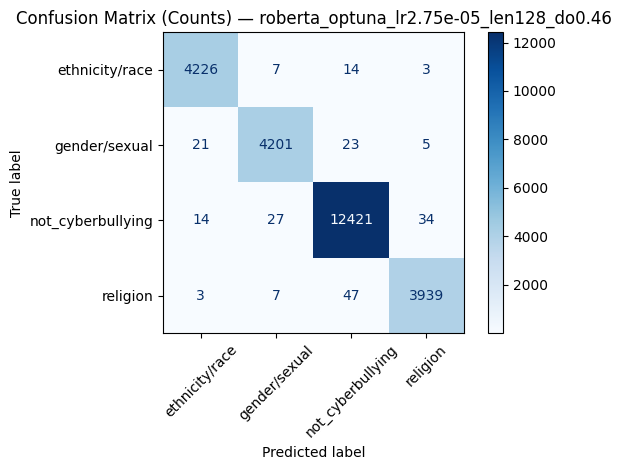

[I 2025-12-18 20:47:47,235] Trial 2 finished with value: 0.9915572983354674 and parameters: {'lr': 2.745996246832474e-05, 'max_len': 128, 'dropout': 0.4641875377056605}. Best is trial 0 with value: 0.9917173495518566.


Best params: {'lr': 2.342457631106799e-05, 'max_len': 128, 'dropout': 0.23060674293378702}
Best best_val_acc: 0.9917173495518566


In [24]:
import optuna

def objective(trial):
    set_seed(42)

    lr = trial.suggest_float("lr", 1e-5, 5e-5, log=True)
    max_len = trial.suggest_categorical("max_len", [100, 128])
    dropout = trial.suggest_float("dropout", 0.20, 0.50)

    run_name = f"roberta_optuna_lr{lr:.2e}_len{max_len}_do{dropout:.2f}"
    metrics, _ = run_roberta_experiment(
        run_name=run_name,
        max_len=max_len,
        batch_size=32,
        epochs=2,
        lr=lr,
        dropout=dropout,
        unfreeze_last_n=2,

    )
    return metrics["best_val_acc"]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)  # increase to 8–12 if you want

print("Best params:", study.best_params)
print("Best best_val_acc:", study.best_value)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[roberta_final_best] Epoch 1/5 | Train Loss 0.1676 Acc 94.27% | Val Loss 0.0522 Acc 98.78%
✅ Best model updated in memory (Val Acc 98.78%)
[roberta_final_best] Epoch 2/5 | Train Loss 0.0476 Acc 98.75% | Val Loss 0.0400 Acc 99.17%
✅ Best model updated in memory (Val Acc 99.17%)
[roberta_final_best] Epoch 3/5 | Train Loss 0.0329 Acc 99.12% | Val Loss 0.0400 Acc 99.13%
[roberta_final_best] Epoch 4/5 | Train Loss 0.0261 Acc 99.25% | Val Loss 0.0389 Acc 99.00%
[roberta_final_best] Epoch 5/5 | Train Loss 0.0201 Acc 99.42% | Val Loss 0.0397 Acc 99.21%
✅ Best model updated in memory (Val Acc 99.21%)
[roberta_final_best] Training time: 1452.16 seconds

✅ TEST RESULTS | Loss: 0.0330 | Accuracy: 99.29%

Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.99      1.00      0.99      4250
    gender/sexual       0.99      0.99      0.99      4250
not_cyberbullying       0.99      0.99      0.99     12496
         religion       0.99      0.99

<Figure size 700x600 with 0 Axes>

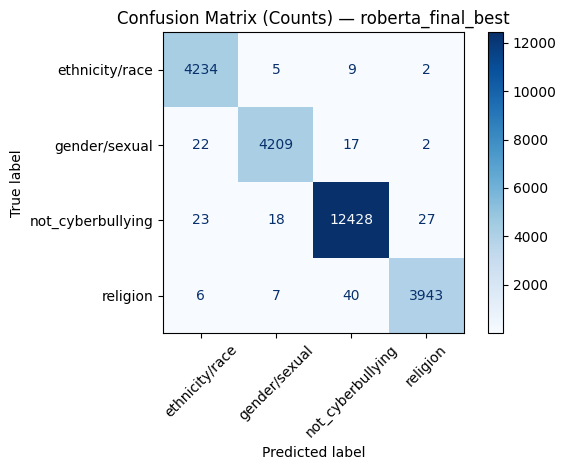

In [25]:
best_params = {
    "lr": 2.342457631106799e-05,
    "max_len": 128,
    "dropout": 0.23060674293378702
}

set_seed(42)

final_metrics, final_history = run_roberta_experiment(
    run_name="roberta_final_best",
    max_len=best_params["max_len"],
    batch_size=32,
    epochs=5,
    lr=best_params["lr"],
    dropout=best_params["dropout"],
    unfreeze_last_n=2
)
